In [1]:
import os
from py2neo import Graph, Node, Relationship
from itertools import permutations
from shapely.geometry import Point, LineString
from geopy.distance import geodesic
import uuid  
from typing import Dict, List, Optional, Union, Tuple
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import itertools

In [2]:

user = os.getenv("DB_USER")
password = os.getenv("DB_PASS")
graph_db: Graph = Graph("bolt://localhost:7687", auth=(user, password))

In [23]:
def shortPathByPOI(
    poiId1: str, 
    poiId2: str
) -> Optional[Dict[str, Union[float, List[str]]]]:

    if not poiId1 or not isinstance(poiId1, str):
        print(f"Invalid poiId1: {poiId1}")
        return None
    if not poiId2 or not isinstance(poiId2, str):
        print(f"Invalid poiId2: {poiId2}")
        return None
    
    query = '''
    MATCH (poi1:POI {osmid: $poiId1})-[:CONNECTED_TO]->(start:Node),
          (poi2:POI {osmid: $poiId2})-[:CONNECTED_TO]->(end:Node)
    CALL apoc.algo.dijkstra(start, end, 'ROAD_TO>', 'length') 
    YIELD path, weight
    RETURN 
        weight AS totalLength,
        [rel IN relationships(path) | id(rel)] AS streetsIds
    '''
    
    try:
        result = graph_db.run(query, poiId1=poiId1, poiId2=poiId2).data()
        
        if not result:
            print(f"No path found between POIs {poiId1} and {poiId2}")
            return None

        data = result[0]
        
        if 'totalLength' not in data or 'streetsIds' not in data:
            print(f"Unexpected result structure: {data}")
            return None
        
        return {
            "totalLength": round(data['totalLength'], 2),  
            "streetsIds": data['streetsIds'],
        }

    except Exception as e:
        print(f"An error occurred while querying the database: {str(e)}")
        return None


In [19]:

def getRoads() -> Optional[List[Dict[str, Union[int, float, str]]]]:
    query = '''
    MATCH (a)-[r:ROAD_TO]->(b)
    WHERE a.latitude IS NOT NULL AND a.longitude IS NOT NULL
      AND b.latitude IS NOT NULL AND b.longitude IS NOT NULL
    RETURN id(a) AS from_id, id(b) AS to_id,
           a.latitude AS from_lat, a.longitude AS from_lon,
           b.latitude AS to_lat, b.longitude AS to_lon,
           r.length AS length, id(r) AS rel_id,
           r.highway AS highway, r.name AS name, r.oneway AS oneway
    '''

    try:
        result = graph_db.run(query).data()

        if not result:
            print("No roads found. The query returned no data.")
            return []

        roads = []
        for record in result:
            road = {}

            if 'from_id' in record and 'to_id' in record:
                road['from_id'] = record['from_id']
                road['to_id'] = record['to_id']
            else:
                print(f"Missing ids for road: {record}")
                continue

            road['from_lat'] = record.get('from_lat', None)
            road['from_lon'] = record.get('from_lon', None)
            road['to_lat'] = record.get('to_lat', None)
            road['to_lon'] = record.get('to_lon', None)

            road['length'] = record.get('length', 0.0) 
            road['rel_id'] = record.get('rel_id', None)

            road['highway'] = record.get('highway', None)
            road['name'] = record.get('name', None)
            road['oneway'] = record.get('oneway', None)

            roads.append(road)

        return roads

    except Exception as e:
        print(f"An error occurred while fetching roads: {str(e)}")
        return []


In [20]:

def findPoiByLatAndLog(lat: float, lon: float) -> Optional[Dict[str, Union[str, float]]]:
    if not isinstance(lat, (float, int)) or not isinstance(lon, (float, int)):
        print(f"Erro: latitude ou longitude fornecida não são válidas. Latitude: {lat}, Longitude: {lon}")
        return None
    if not (-90 <= lat <= 90) or not (-180 <= lon <= 180):
        print(f"Erro: valores de latitude ou longitude fora do intervalo válido. Latitude: {lat}, Longitude: {lon}")
        return None
    query = '''
    MATCH (poi:POI)
    WHERE poi.latitude = $lat AND poi.longitude = $lon
    RETURN poi.osmid AS osmid, poi.name AS name, poi.latitude AS latitude, poi.longitude AS longitude
    '''
    try:
        result = graph_db.run(query, lat=lat, lon=lon).data()
        if not result:
            print(f"Aviso: Nenhum POI encontrado para Latitude: {lat}, Longitude: {lon}")
            return None
        data = result[0]
        if 'osmid' not in data or 'name' not in data or 'latitude' not in data or 'longitude' not in data:
            print(f"Erro: Estrutura de dados inesperada retornada. Dados: {data}")
            return None
        return {
            "osmid": data['osmid'],
            "name": data['name'],
            "latitude": data['latitude'],
            "longitude": data['longitude']
        }

    except Exception as e:
        print(f"Erro ao executar a consulta: {str(e)}")
        return None


In [ ]:

def insert_poi(lat: float, lon: float, name:str,label='POI') -> Node:
    node = findPoiByLatAndLog(lat, lon)
    if(node):
        return node
    roads = getRoads()
    poi_point = Point(lon, lat)
    closest = None
    min_dist = float('inf')
    # Encontrar a aresta mais próxima ao ponto informado
    for road in roads:
        a = Point(road['from_lon'], road['from_lat'])
        b = Point(road['to_lon'], road['to_lat'])
        line = LineString([a, b])
        proj = line.interpolate(line.project(poi_point))
        dist = geodesic((lat, lon), (proj.y, proj.x)).meters

        if dist < min_dist:
            min_dist = dist
            closest = {**road, 'proj_point': proj}

    if not closest:
        print("Nenhuma aresta próxima encontrada.")
        return

    proj = closest['proj_point']

    # Criar novo nó intermediário na malha viária
    mid_node = Node("Node",
                    latitude=proj.y,
                    longitude=proj.x,
                    osmid=str(uuid.uuid4()))
    
    graph_db.create(mid_node)
    
    poi_node = Node(label,
                    name=name,
                    latitude=lat,
                    longitude=lon,
                    osmid=str(uuid.uuid4())
                    )
    graph_db.create(poi_node)

    graph_db.create(Relationship(poi_node, "CONNECTED_TO", mid_node,
                                 distance=min_dist))

    # Remover aresta original
    graph_db.run("MATCH ()-[r]->() WHERE id(r) = $id DELETE r", id=closest['rel_id'])

    # Criar novas arestas dividindo a original
    from_id = closest['from_id']
    to_id = closest['to_id']
    mid_id = mid_node.identity

    len1 = geodesic((closest['from_lat'], closest['from_lon']), (proj.y, proj.x)).meters
    len2 = geodesic((closest['to_lat'], closest['to_lon']), (proj.y, proj.x)).meters

    graph_db.run('''
        MATCH (a), (b), (c)
        WHERE id(a) = $from_id AND id(b) = $to_id AND id(c) = $mid_id
        CREATE (a)-[:ROAD_TO {
            length: $len1,
            highway: $highway,
            name: $name,
            oneway: $oneway
        }]->(c),
        (c)-[:ROAD_TO {
            length: $len2,
            highway: $highway,
            name: $name,
            oneway: $oneway
        }]->(b)
    ''', parameters={
        "from_id": from_id,
        "to_id": to_id,
        "mid_id": mid_id,
        "len1": len1,
        "len2": len2,
        "highway": closest['highway'],
        "name": closest['name'],
        "oneway": closest['oneway'],
    })
    
    print(f"POI criado e conectado no ponto mais próximo da rua: {closest['name'] or 'desconhecida'}")
    return poi_node

In [62]:
def plotGrahp(points: List[Tuple[float, float, str]], coloredStreets: Optional[List[str]]= None) -> None:
    colors = itertools.cycle(plt.cm.tab10.colors)
    
    query_nodes = '''
    MATCH (n:Node)
    RETURN id(n) AS id, n.latitude AS lat, n.longitude AS lon
    '''

    query_edges = '''
    MATCH (a:Node)-[r:ROAD_TO]->(b:Node)
    RETURN id(r) AS id, 
           id(a) AS source,
           id(b) AS target,
           r.length AS length,
           r.name AS name,
           r.highway AS highway,
           r.oneway AS oneway
    '''

    nodes_df = pd.DataFrame(graph_db.run(query_nodes).data())
    edges_df = pd.DataFrame(graph_db.run(query_edges).data())

    G = nx.MultiDiGraph()
    G.graph['crs'] = 'epsg:4326'

    for _, row in nodes_df.iterrows():
        G.add_node(row['id'], x=row['lon'], y=row['lat'])

    for _, row in edges_df.iterrows():
        G.add_edge(
            row['source'],
            row['target'],
            key=row['id'],
            id=row['id'],
            length=row['length'],
            name=row['name'],
            highway=row['highway'],
            oneway=row['oneway'],
        )

    # Cores das ruas
    edge_colors = []
    for u, v, k, data in G.edges(keys=True, data=True):
        # display(data.get('id'), (data.get('id')) in coloredStreets)
        if(coloredStreets is None): edge_colors.append('lightgray')
        if coloredStreets and data.get('id') in coloredStreets:
            edge_colors.append('blue')
        else:
            edge_colors.append('lightgray')

    fig, ax = plt.subplots(figsize=(10, 10))

    ox.plot_graph(
        G,
        ax=ax,
        node_size=0.2,
        node_color="black",
        edge_color=edge_colors,
        edge_linewidth=0.7,
        bgcolor="white",
        show=False,
        close=False
    )

    plotLatAndLon = list(map(lambda poi: (poi['longitude'], poi['latitude'], poi['name']), points))
    for lon, lat, name in plotLatAndLon:
        color = next(colors)
        ax.scatter(lon, lat, c=[color], s=10, marker='o', zorder=10, label=name)

    ax.legend(loc='upper right', fontsize=10)
    plt.show()


In [8]:

initialPoint = insert_poi(lat=-23.2848682, lon=-47.6720885, name='Ponto Inicial')

target_points = [
    insert_poi(lat=-23.2999866, lon=-47.6650897, name='Ponto 1'),
    insert_poi(lat=-23.2829741, lon=-47.6745936, name='Ponto 2'),
    insert_poi(lat=-23.276087796084404, lon=-47.67514362249426, name='Ponto 3'),
]

display(initialPoint, target_points)

POI já existe nesse ponto.
POI já existe nesse ponto.
POI já existe nesse ponto.
POI já existe nesse ponto.


{'osmid': '197aa31f-3c20-42b2-afdf-5e0b92a602a5',
 'name': 'Ponto Inicial',
 'latitude': -23.2848682,
 'longitude': -47.6720885}

[{'osmid': '9e573839-8b59-499f-80d9-1402d4a6680b',
  'name': 'Ponto 1',
  'latitude': -23.2999866,
  'longitude': -47.6650897},
 {'osmid': 'eba6e7a5-f155-4a7e-b141-cac6ab3fb2ca',
  'name': 'Ponto 2',
  'latitude': -23.2829741,
  'longitude': -47.6745936},
 {'osmid': '3d620160-bc2a-4c2e-991b-6467bea3cb7e',
  'name': 'Ponto 3',
  'latitude': -23.276087796084404,
  'longitude': -47.67514362249426}]

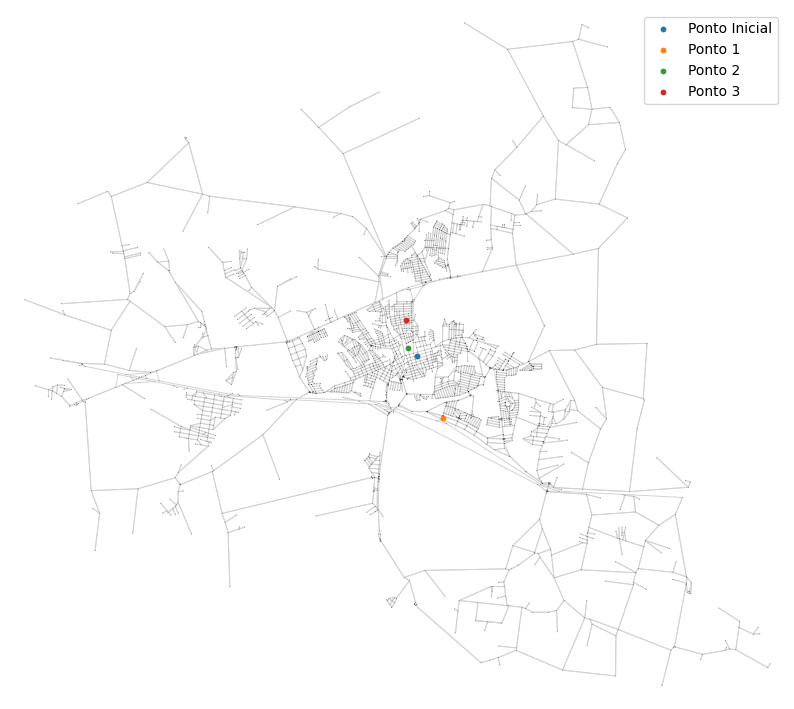

In [63]:
_points = list([initialPoint, *target_points])
plotGrahp(points=_points)


In [54]:
def brute_force_shortest_path(initialpoint: Node, points: List[Node]) -> Tuple[List[Node], float, list[str]]:
    min_distance = float('inf')
    best_path = None
    best_street_sequence = []
    pointer = 0

    for perm in permutations(points):
        path = [initialpoint, *perm, initialpoint]
        total_distance = 0
        pointer += 1
        street_sequence = []

        for i in range(len(path) - 1):
            segment = shortPathByPOI(path[i]['osmid'], path[i + 1]['osmid'])
            if not segment:
                total_distance = float('inf')
                break
            total_distance += segment.get('totalLength', 0)
            street_sequence.extend(segment.get('streetsIds', []))

        if total_distance < min_distance:
            min_distance = total_distance
            best_path = path[:]  # copia correta
            best_street_sequence = street_sequence[:]

    print('Número de interações:', pointer)
    return best_path, min_distance, best_street_sequence


Número de interações: 6
Menor caminho:  ['Ponto Inicial', 'Ponto 1', 'Ponto 2', 'Ponto 3', 'Ponto Inicial']
Menor distância (m):  9197.890000000001


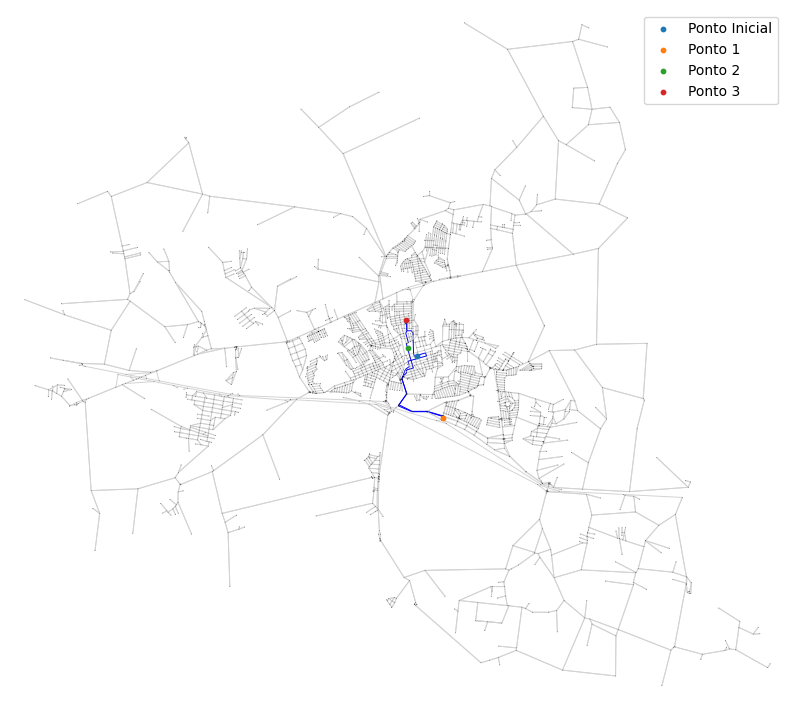

In [59]:
best_path, min_distance, best_street_sequence  = brute_force_shortest_path(initialpoint=initialPoint, points=target_points)
print("Menor caminho: ", list(map(lambda p: p['name'], best_path)))
print("Menor distância (m): ", min_distance)
plotGrahp(points=_points, coloredStreets=best_street_sequence)